# Explore the dataset

In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt

In [48]:
# plot utilies

def plot_field(field):
    '''field: shape [x, y]'''
    fig, axs = plt.subplots(4,4, figsize=(10,8))
    for i, ax in enumerate(axs.ravel()):
        im = ax.imshow(field[...,i].T, 
                cmap='inferno',
                origin='lower',
                aspect='auto')
        ax.set_box_aspect(1)
        ax.axis('off')
        fig.colorbar(im)
    plt.tight_layout()
    plt.show()
    return fig



In [30]:
# Load the data set

data = h5py.File('/pscratch/sd/y/yixuans/datatset/SOMA/varyGM/thedataset2.hdf5', 'r')
print(data.keys())
print(len(data.keys()))

<KeysViewHDF5 ['forward_0', 'forward_1', 'forward_10', 'forward_11', 'forward_12', 'forward_13', 'forward_14', 'forward_15', 'forward_16', 'forward_17', 'forward_18', 'forward_19', 'forward_2', 'forward_20', 'forward_21', 'forward_22', 'forward_23', 'forward_24', 'forward_25', 'forward_26', 'forward_27', 'forward_28', 'forward_29', 'forward_3', 'forward_30', 'forward_31', 'forward_32', 'forward_33', 'forward_34', 'forward_35', 'forward_36', 'forward_37', 'forward_38', 'forward_39', 'forward_4', 'forward_40', 'forward_41', 'forward_42', 'forward_43', 'forward_44', 'forward_45', 'forward_46', 'forward_47', 'forward_48', 'forward_49', 'forward_5', 'forward_50', 'forward_51', 'forward_52', 'forward_53', 'forward_54', 'forward_55', 'forward_56', 'forward_57', 'forward_58', 'forward_59', 'forward_6', 'forward_60', 'forward_61', 'forward_62', 'forward_63', 'forward_64', 'forward_65', 'forward_66', 'forward_67', 'forward_68', 'forward_69', 'forward_7', 'forward_70', 'forward_71', 'forward_72',

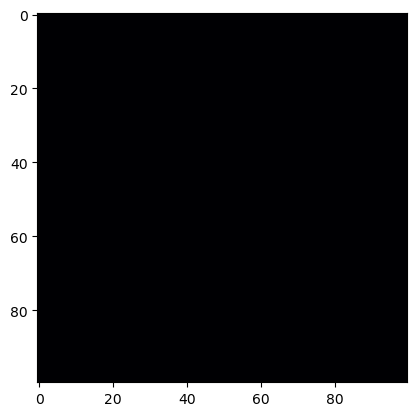

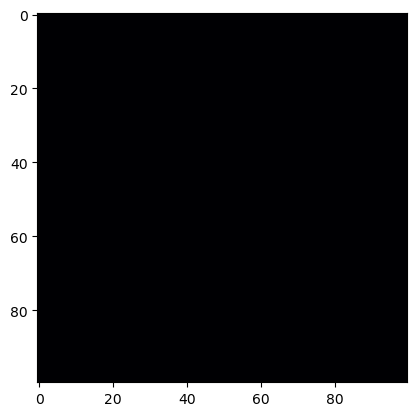

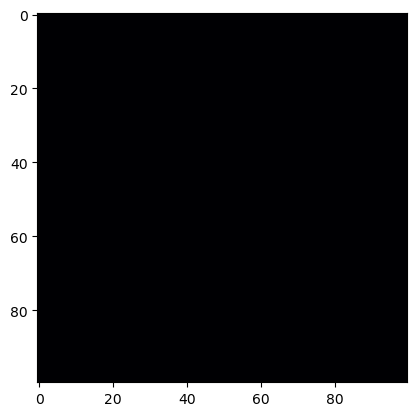

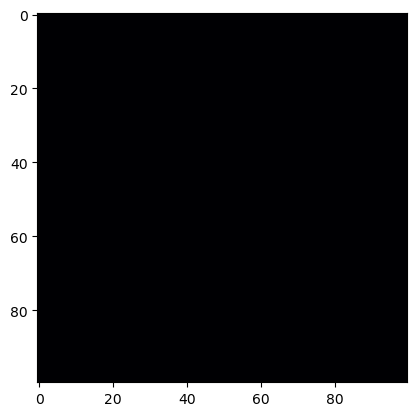

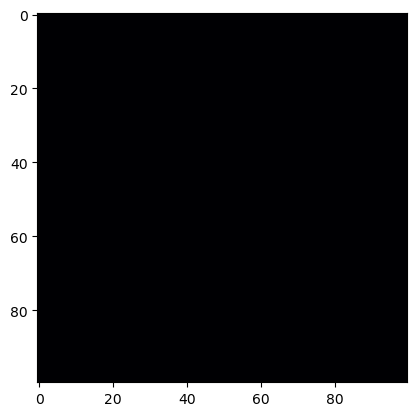

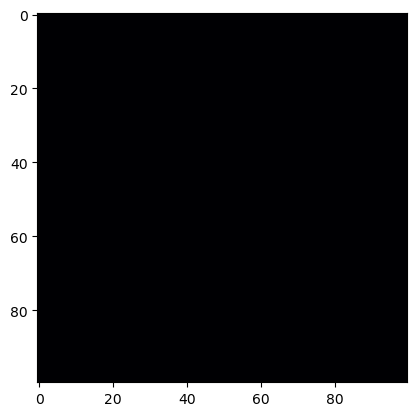

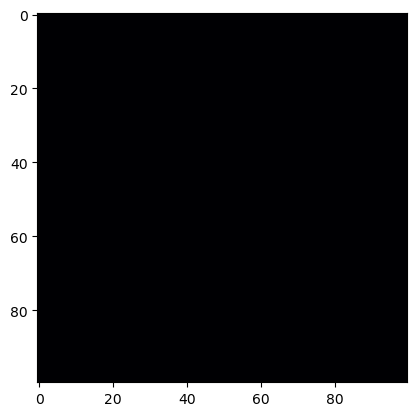

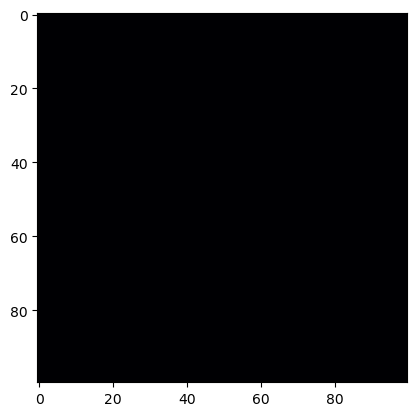

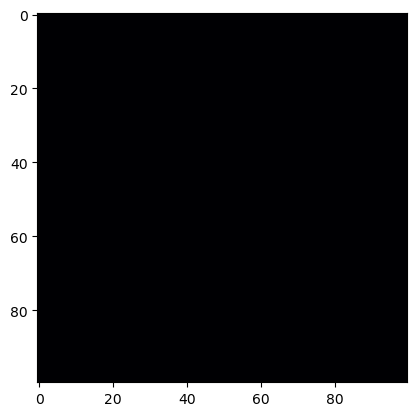

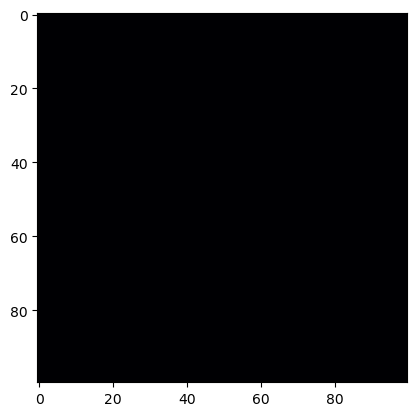

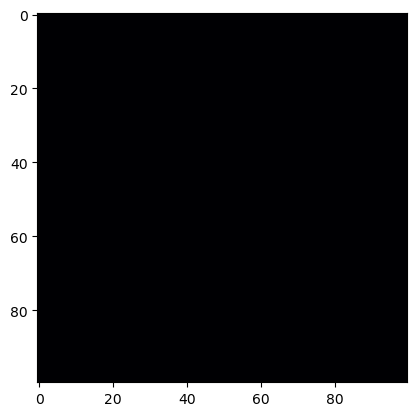

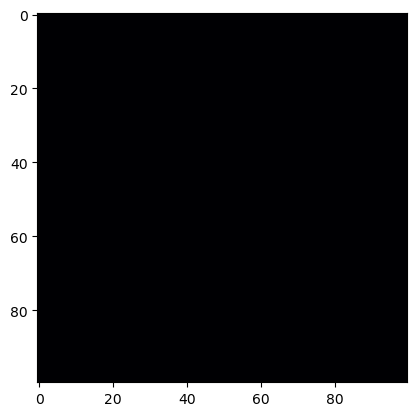

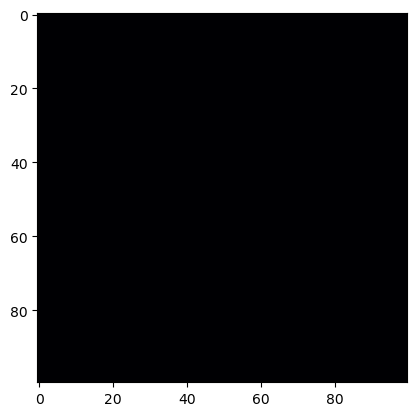

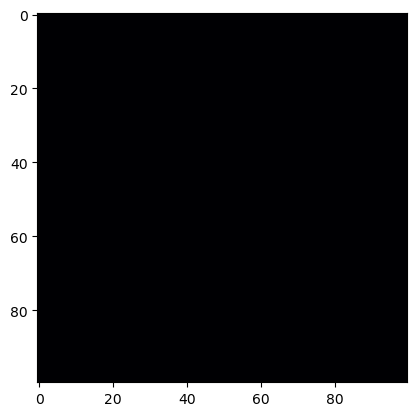

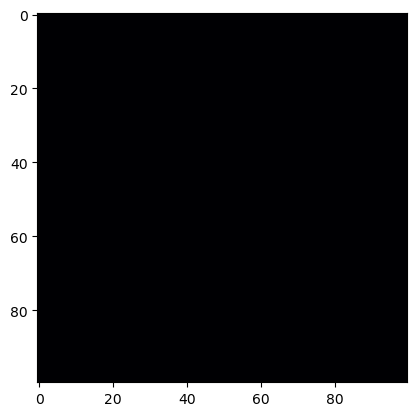

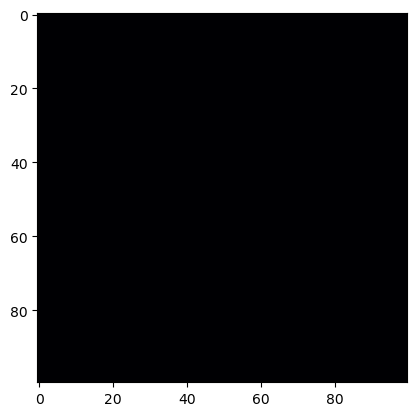

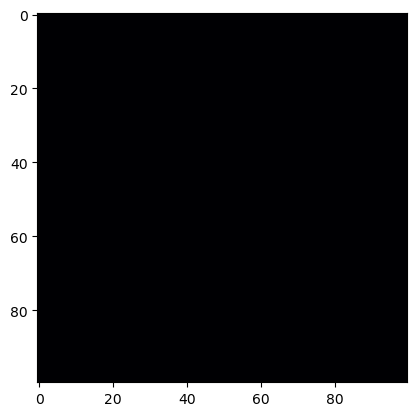

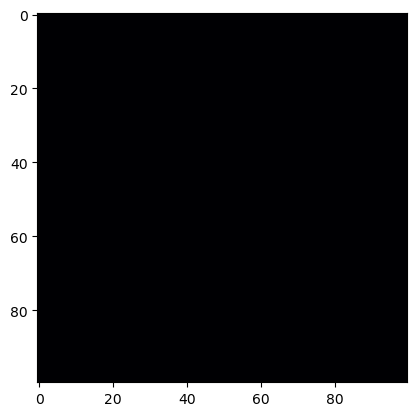

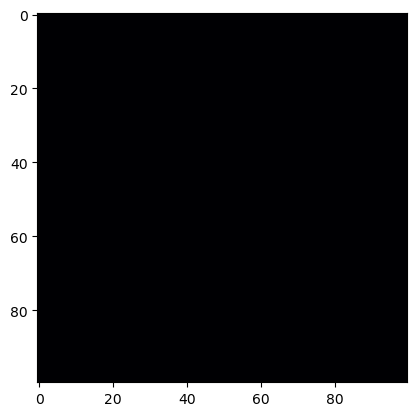

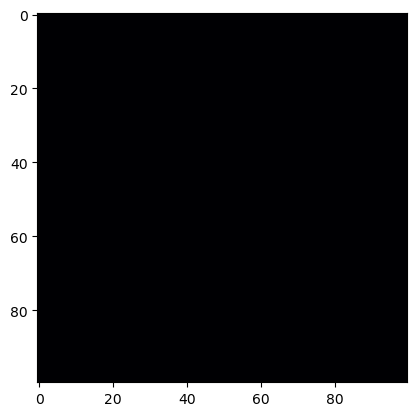

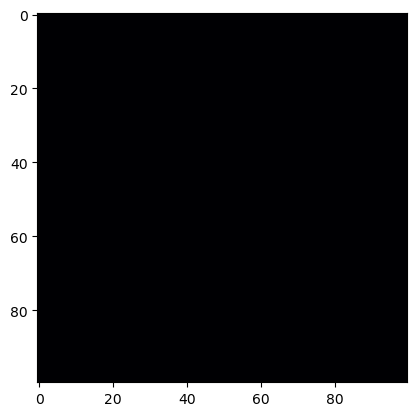

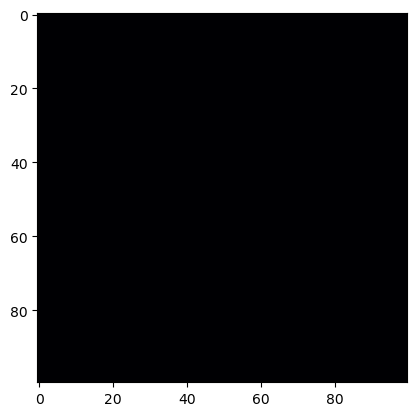

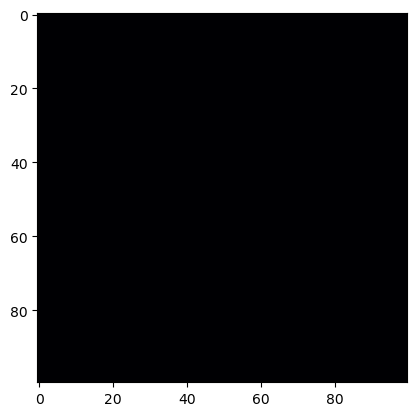

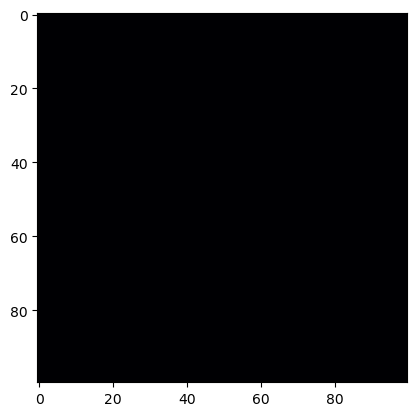

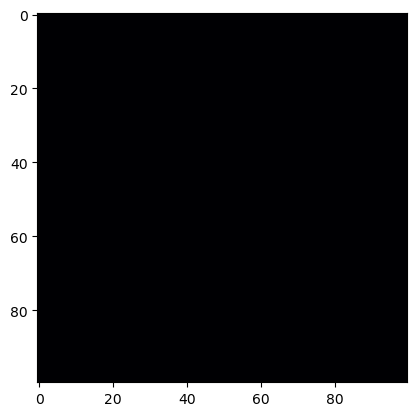

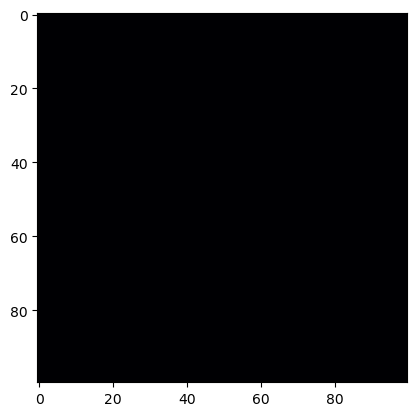

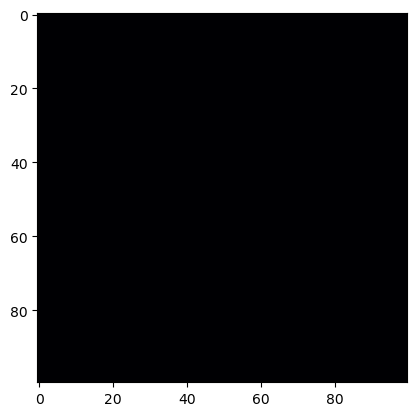

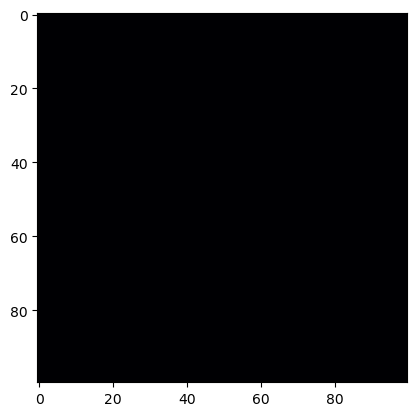

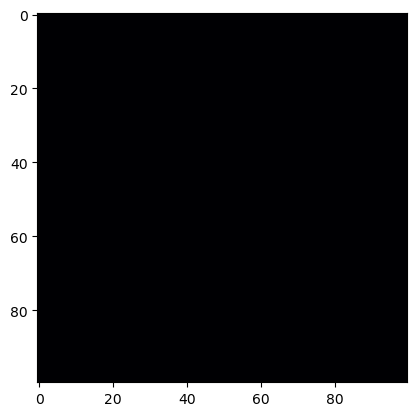

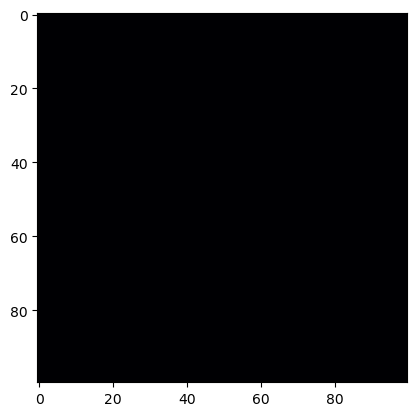

In [64]:
forward_0 = data['forward_0'][...]
mask1 = forward_0 < -1e16
mask2 = forward_0 > 1e16
forward_0[mask1] = np.nan
forward_0[mask2] = np.nan

# import pickle

# with open('../tmp/SOMA_mask.pkl', 'wb') as f:
#     mask = {'mask1': mask1, 'mask2': mask2}
#     pickle.dump(mask, f)
# plot_field(forward_0[29, 0, :, :,: ])

# get the min max for all variables from the first example
# for i in range(forward_0.shape[-1]):
#     print((np.nanmin(forward_0[..., i]), np.nanmax(forward_0[..., i])))


# investigate where 0 is coming from in GM
mask_0 = forward_0[...,-1] == 0
a = forward_0
a[mask_0] = 500
for i in range(forward_0.shape[0]):
    plt.imshow(a[i,0, ..., -1], cmap='inferno')
    plt.show()

